
--- Reading 'qm2n2' vs. L from aggregated files for S=1 ---
  L=10: Found value = 0.031490 \pm 0.000005
  L=20: Found value = 0.027550 \pm 0.000007
  L=30: Found value = 0.026492 \pm 0.000006
  L=50: Found value = 0.025730 \pm 0.000008
  L=80: Found value = 0.025339 \pm 0.000007
  L=120: Found value = 0.025110 \pm 0.000010
--- Performing fit for S=1, L >= 15 ---
Fit Results:
  O(inf) = 0.024801 \pm 0.000017
  c      = 0.0966 \pm 0.0044
  Delta  = 1.1883 \pm 0.0169


/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90630/2864975848.py:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True)
/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90630/2864975848.py:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True)
/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90630/2864975848.py:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True)
/var/folders/26/b_j5qbw50rx0y2hh_svmqm100000gn/T/ipykernel_90630/2864975848.py:56: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be

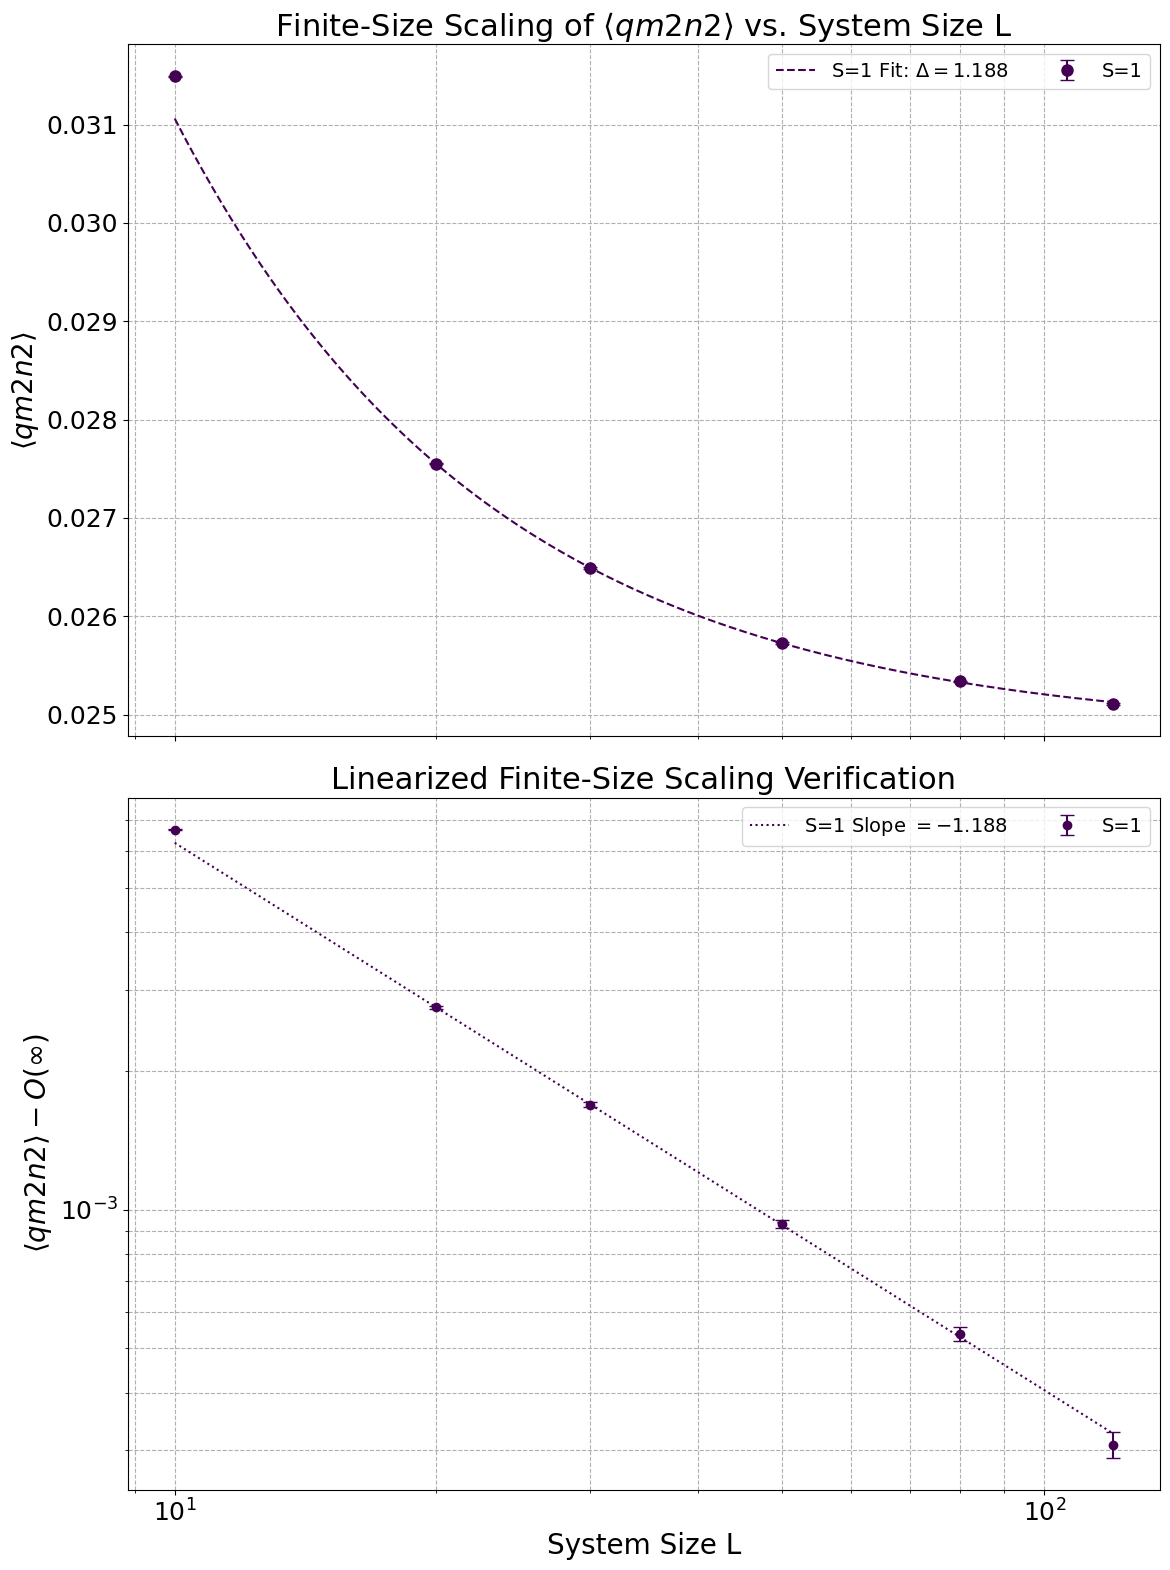


Final plot saved successfully as fig/fss_fit_qm2n2_vs_L.png

 Summary of Finite-Size Scaling Fit Results

S = 1:
  O(inf) = 0.024801 \pm 0.000017
  c      = 0.0966 \pm 0.0044
  Delta  = 1.1883 \pm 0.0169


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
import glob

# --- Matplotlib Global Settings ---
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

# --- Model Function for Fitting (Unchanged) ---
def finite_size_scaling_func(L, O_inf, c, Delta):
    """Represents the model O(L) = O(inf) + c * L^(-Delta)."""
    return O_inf + c * np.power(np.float64(L), -Delta)

# --- MODIFIED Data Processing and Plotting Function ---
def process_and_plot_single_S(L_values_to_check, S_value, observable_name, ax1, ax2, data_label, plot_color,
                              perform_fit=False, fit_L_min=0):
    """
    Reads data from 'final_grand_average_obs.dat' files for a single S value,
    then plots and fits the observable vs. L.
    """
    L_values, obs_values, obs_errors = [], [], []

    print(f"\n--- Reading '{observable_name}' vs. L from aggregated files for S={S_value} ---")
    
    # Map the script's observable name to the name used in the data file
    # Example: "A_exp" -> "A"
    file_obs_name = observable_name.replace('_exp', '')

    for L in L_values_to_check:
        # Find the correct parameter directory for the given L and S
        # The glob pattern '*' handles variations in T and Tthermal
        search_pattern = f"./puredata/data/L{L}_S{S_value}_*"
        matching_dirs = glob.glob(search_pattern)

        if not matching_dirs:
            continue  # Silently skip if no directory for this L and S exists

        # Construct the full path to the aggregated data file
        filepath = os.path.join(matching_dirs[0], "final_grand_average_obs.dat")
        
        if not os.path.exists(filepath):
            print(f"  Warning: File not found: {filepath}")
            continue
        
        try:
            # Read the aggregated data file using pandas
            df = pd.read_csv(filepath, delim_whitespace=True)
            
            # Check if the desired observable is present in the file
            if file_obs_name in df['Observable'].values:
                # Extract the specific row for our observable
                obs_data = df[df['Observable'] == file_obs_name].iloc[0]
                avg_val = obs_data['Avg_Value']
                err_val = obs_data['Err_Value']

                L_values.append(L)
                obs_values.append(avg_val)
                obs_errors.append(err_val)
                print(f"  L={L}: Found value = {avg_val:.6f} \pm {err_val:.6f}")
            else:
                print(f"  L={L}: Observable '{file_obs_name}' not found in {filepath}")

        except Exception as e:
            print(f"  Error reading or parsing file {filepath}: {e}")
            continue
    
    if not L_values:
        print(f"Error: No data found to plot for S={S_value}.")
        return None, None

    # --- Sorting, Plotting, and Fitting logic is unchanged ---
    sorted_indices = np.argsort(L_values)
    L_values, obs_values, obs_errors = (
        np.array(L_values)[sorted_indices], 
        np.array(obs_values)[sorted_indices], 
        np.array(obs_errors)[sorted_indices]
    )

    # Plot 1: O(L) vs L
    ax1.errorbar(L_values, obs_values, yerr=obs_errors, 
                 fmt='o', markersize=8, capsize=5, color=plot_color, 
                 label=data_label)
    
    popt, perr = None, None

    if perform_fit:
        fit_mask = L_values >= fit_L_min
        if np.sum(fit_mask) < 3:
            print(f"Warning: Need at least 3 data points for the fit for S={S_value}. Skipping fit.")
        else:
            L_fit_data, obs_fit_data, err_fit_data = L_values[fit_mask], obs_values[fit_mask], obs_errors[fit_mask]
            
            initial_guesses = [obs_fit_data[-1], 1.0, 1.0]
            print(f"--- Performing fit for S={S_value}, L >= {fit_L_min} ---")

            try:
                popt, pcov = curve_fit(finite_size_scaling_func, L_fit_data, obs_fit_data,
                                       p0=initial_guesses, sigma=err_fit_data, absolute_sigma=True)
                perr = np.sqrt(np.diag(pcov))
                
                O_inf_fit, c_fit, Delta_fit = popt
                O_inf_err, c_err, Delta_err = perr

                print("Fit Results:")
                print(f"  O(inf) = {O_inf_fit:.6f} \pm {O_inf_err:.6f}")
                print(f"  c      = {c_fit:.4f} \pm {c_err:.4f}")
                print(f"  Delta  = {Delta_fit:.4f} \pm {Delta_err:.4f}")

                L_smooth = np.logspace(np.log10(L_values.min()), np.log10(L_values.max()), 200)
                fit_curve = finite_size_scaling_func(L_smooth, *popt)
                ax1.plot(L_smooth, fit_curve, color=plot_color, linestyle='--', 
                         label=f'{data_label} Fit: $\Delta = {Delta_fit:.3f}$')
                
                y_linear = obs_values - O_inf_fit
                y_linear_err = np.sqrt(obs_errors**2 + O_inf_err**2)
                plot_mask = y_linear > 0
                
                ax2.errorbar(L_values[plot_mask], y_linear[plot_mask], yerr=y_linear_err[plot_mask],
                             fmt='o', color=plot_color, capsize=5, 
                             label=data_label)
                
                line_theory = c_fit * np.power(L_smooth, -Delta_fit)
                ax2.plot(L_smooth, line_theory, color=plot_color, linestyle=':',
                         label=f'{data_label} Slope $= -{Delta_fit:.3f}$')

            except RuntimeError:
                print(f"Error: The fit for S={S_value} did not converge.")
                return None, None
    return popt, perr

# ===============================================================
# MAIN SCRIPT CONFIGURATION
# ===============================================================
if __name__ == '__main__':
    
    # 1. CHOOSE THE OBSERVABLE TO PLOT
    #    (Use a name like "A_exp", "B_exp", "pm0_exp", etc.)
    OBSERVABLE_TO_PLOT = "qm2n2"
    
    # 2. CHOOSE S AND L VALUES TO ANALYZE
    S_values_to_run = [1]
    L_values_to_check = [10, 20, 30, 50, 80, 100, 120]

    # 3. CONFIGURE THE FIT
    DO_FIT = True
    FIT_L_MIN = 15 # Start fitting from L=50
    
    # --- Script execution starts here ---
    
    output_dir = "fig"
    os.makedirs(output_dir, exist_ok=True)
    output_filename = os.path.join(output_dir, f"fss_fit_{OBSERVABLE_TO_PLOT}_vs_L.png")

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16), sharex=True)
    all_fit_results = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(S_values_to_run)))
    
    # Loop over S values and plot onto the shared axes
    for i, S in enumerate(S_values_to_run):
        popt, perr = process_and_plot_single_S(
            L_values_to_check=L_values_to_check,
            S_value=S,
            observable_name=OBSERVABLE_TO_PLOT,
            ax1=ax1, ax2=ax2,
            data_label=f'S={S}',
            plot_color=colors[i],
            perform_fit=DO_FIT,
            fit_L_min=FIT_L_MIN
        )
        if popt is not None:
            all_fit_results[S] = {'popt': popt, 'perr': perr}
            
    # --- Finalize Plots ---
    obs_base_name = OBSERVABLE_TO_PLOT.replace('_exp', '')
    # This logic correctly handles special names like 'pm0' and regular names like 'A'
    if 'pm' in obs_base_name:
        plot_title_obs = obs_base_name.replace('pm', 'P_{m=') + '}'
    else:
        plot_title_obs = obs_base_name

    ax1.set_ylabel(f"$\langle {plot_title_obs} \\rangle$")
    ax1.set_title(f"Finite-Size Scaling of $\langle {plot_title_obs} \\rangle$ vs. System Size L")
    ax1.set_xscale('log'); ax1.set_yscale('linear')
    ax1.grid(True, which="both", ls="--")
    ax1.legend(loc='best', ncol=2)
    
    O_inf_str = r'O(\infty)'
    ax2.set_ylabel(f"$\langle {plot_title_obs} \\rangle - {O_inf_str}$")
    ax2.set_xlabel("System Size L")
    ax2.set_title("Linearized Finite-Size Scaling Verification")
    ax2.set_xscale('log'); ax2.set_yscale('log')
    ax2.grid(True, which="both", ls="--")
    ax2.legend(loc='best', ncol=2)
    
    plt.tight_layout(pad=1.0)
    # plt.savefig(output_filename)
    plt.show()
    plt.close(fig)
    print(f"\nFinal plot saved successfully as {output_filename}")

    if all_fit_results:
        print("\n" + "="*50)
        print(" Summary of Finite-Size Scaling Fit Results")
        print("="*50)
        for S, res in all_fit_results.items():
            popt, perr = res['popt'], res['perr']
            print(f"\nS = {S}:")
            print(f"  O(inf) = {popt[0]:.6f} \pm {perr[0]:.6f}")
            print(f"  c      = {popt[1]:.4f} \pm {perr[1]:.4f}")
            print(f"  Delta  = {popt[2]:.4f} \pm {perr[2]:.4f}")